# Statistics on the output data. 

### Loading data from the sqlite database to the dataframes

In [271]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lizard
import subprocess as sub
from pylibsrcml import srcml
import os
import re 
import xml.etree.ElementTree as et 
import warnings
from sqlite3 import connect
from argparse import ArgumentParser
from configparser import ConfigParser
import yaml
from pathlib import Path
import random
from tabulate import tabulate

warnings.filterwarnings("ignore")


# database = '../data/IoT.db'
# database = '../data/TinyVul.db'
database = "/Users/guru/research/TinyVul-v2-copy.db"
conn= connect(database)

random.seed(0)

dfp = pd.read_sql_query("SELECT * FROM project", con=conn)
dfs = pd.read_sql_query("SELECT * FROM statement", con=conn)
dff = pd.read_sql_query("SELECT * FROM function", con=conn)

if not os.path.exists("figure"):
    os.mkdir("figure")
dfs.columns

Index(['file', 'line', 'column', 'defaultlevel', 'level', 'category', 'name',
       'msg', 'note', 'cwe', 'context', 'helpuri', 'severity', 'tool', 'type',
       'project'],
      dtype='object')

In [308]:
dff.cwe.value_counts()

Benign         121566
CWE-unknown     20724
Name: cwe, dtype: int64

### Plotting subburset plot from the frequency of category, name and cwe types. 

In [272]:
dfplt = dfs[['category', 'name', 'cwe']].groupby(['category', 'name', 'cwe'], group_keys=False).size().reset_index(name='count')

dfplt['category'] = dfplt.apply(lambda row: row['category'] 
if row['category']==row['name'] or row['name']=='-' 
else row['name'], axis=1)
dfplt = dfplt.drop(labels=['name'], axis=1)

fig = px.sunburst(dfplt, 
    path=['category', 'cwe'], 
    values='count', 
    color_continuous_scale='Blues',
    color='count',
)
# fig.write_image("figure/vul_statistics.pdf")
# fig.update_traces(hovertemplate='%{label}<br>%{customdata}')
fig.update_layout(
    autosize=False,
    width=800,
    height=800,)
fig.show()
# save the figure manually, the below code takes ages
# fig.write_image("../figure/vul_statistics.pdf")

In [274]:
dfplt.sort_values(by=['count'], ascending=False).head(10)

,category,cwe,count
100,memcpy,CWE-unknown,7396
54,memcpy,CWE-120,7000
43,char,CWE-119!/CWE-120,6425
75,fixed size global buffer,CWE-unknown,3421
59,sprintf,CWE-120,2429
127,snprintf,CWE-unknown,2245
64,strlen,CWE-126,1715
135,strlen,CWE-unknown,1639
36,Static Global Buffer,CWE-unknown,1228
10,integerOverflow,CWE-190,1085


# Top 10 vulnerabilities

In [275]:
df_top10 = dfplt.sort_values(by=['count'], ascending=False).head(10).reset_index(drop=True)
print(tabulate(df_top10, headers='keys', tablefmt='psql'))
df_top10.to_latex("../result/top10.tex", index=False, caption="Top 10 CWEs in IoT code")

+----+--------------------------+------------------+---------+
|    | category                 | cwe              |   count |
|----+--------------------------+------------------+---------|
|  0 | memcpy                   | CWE-unknown      |    7396 |
|  1 | memcpy                   | CWE-120          |    7000 |
|  2 | char                     | CWE-119!/CWE-120 |    6425 |
|  3 | fixed size global buffer | CWE-unknown      |    3421 |
|  4 | sprintf                  | CWE-120          |    2429 |
|  5 | snprintf                 | CWE-unknown      |    2245 |
|  6 | strlen                   | CWE-126          |    1715 |
|  7 | strlen                   | CWE-unknown      |    1639 |
|  8 | Static Global Buffer     | CWE-unknown      |    1228 |
|  9 | integerOverflow          | CWE-190          |    1085 |
+----+--------------------------+------------------+---------+


<AxesSubplot: >

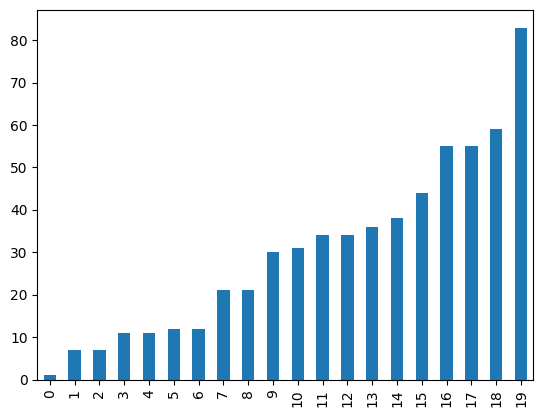

In [276]:
# dfs.context.head(200).str.len().plot(kind='bar')
pd.Series(sorted(list(dfs.context.head(20).str.len()))).plot(kind='bar')

In [277]:
len(dfs[dfs.context=='-'])

19092

In [278]:
len(dfs)

1289594

<AxesSubplot: ylabel='Frequency'>

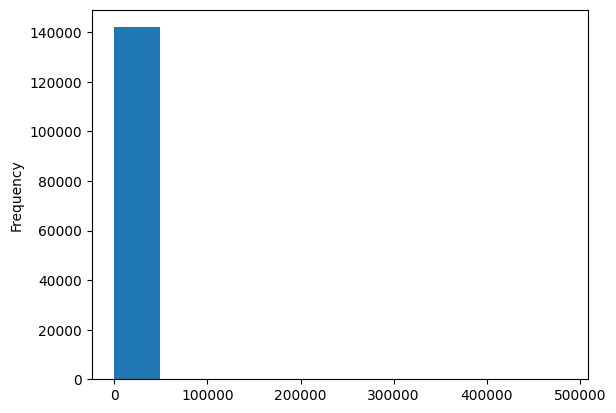

In [279]:
pd.Series([len(x) for x in dff.code if len(x)>10]).plot.hist(xlabel='#chars', ylabel='#statements')

In [280]:
def filter_unusual_statements(statements, min_len, max_len, df):
    """" 
    # https://peps.python.org/pep-0007/
    # https://www.python.org/dev/peps/pep-0007/ 

    """
    filtered_statements = []
    for statement in statements:
        if len(statement) >= min_len and len(statement) <= max_len:
            filtered_statements.append(statement)
   
    # take size of the vul statements as basis
    df = pd.Series(statements)   
    df = df.str.len()
    
    stat_sizes =  list(df[df.between(max_len, min_len)].reset_index(drop=True))
    
    sample_size = 5 if len(stat_sizes)>5 else len(stat_sizes)-1
    stat_sizes = random.sample(set(stat_sizes), sample_size)
    return stat_sizes


# standard variables:
max_len = 79  #TODO: double check pep standards

# TODO: check min_len as well, otherwise the below code unnessesarily checks one extra condition 
# because there is no any statement/fun with len below that. 
# for min_len (eg, 7 characters)
min_len = dfs.context.str.len().sort_values(ascending=False).reset_index(drop=True).min()


lines = dff.code[0].splitlines()
stat_sizes = filter_unusual_statements(lines, max_len, min_len, dfs)
stat_sizes

[11, 23, 0, 37, 13]

In [281]:
# df_dnn = pd.read_csv('../data/iDetect_refine/DNN_Binary.csv')
# df_conti = pd.read_csv('../data/contiki-master_Binary.csv')
# df_rasp = pd.read_csv('../data/raspberry_metrics.csv')
# df_rasp_flaw = pd.read_csv('../data/raspberry_flaw.csv')

# print('Shape of DNN data: ', df_dnn.shape)
# print('Shape of contiki: ', df_conti.shape)
# print('Shape of raspberry: ', df_rasp.shape)
# print('Shape of raspberry flaws: ', df_rasp_flaw.shape)

# dfcon = dfcon.rename(columns={'context': 'code'})
# dfcon.to_csv('../data/contiki-master_Binary.csv', index=False)

## Frequency of the vulnerabilities and benign samples at 
    - statement-level 
    - function-level

In [283]:
# for project-wise distribution
projects = list(dfs.project.unique())

for project in projects:
    print(project)
    df = dfs[dfs.project == project]
    print(df.shape)
    print(df.cwe.value_counts())
    print(df.category.value_counts())
    print('----------------------')

/Users/guru/research/projects/gnucobol
(471813, 16)
Benign              467933
CWE-unknown           1928
CWE-120                890
CWE-119!/CWE-120       455
CWE-126                361
CWE-134                 75
CWE-362                 44
CWE-807, CWE-20         39
CWE-120, CWE-20         33
CWE-362/CWE-367!        28
CWE-78                   7
CWE-190                  7
CWE-120/CWE-785!         4
CWE-562                  3
CWE-327                  3
CWE-829, CWE-20          1
CWE-362, CWE-20          1
CWE-807                  1
Name: cwe, dtype: int64
buffer                      1782
memcpy                       428
strlen                       350
fixed size global buffer     272
snprintf                     265
sprintf                      164
-                            108
format                        75
Static Global Buffer          46
misc                          46
fixed size local buffer       42
getenv                        39
printf                        36
fprintf  

## Create a latex table from the statistics of projects

In [284]:
def save_latex(df, file):
    """
    save the dataframe as latex table
    """
    styler = df.style
    # styler.applymap_index(lambda v: "font-weight: bold;", axis="index")
    styler.applymap_index(lambda v: "font-weight: bold;", axis="columns")
    res = styler.to_latex(convert_css=True, column_format='|l|l|r|')

    with open(file, 'w') as f:
        f.write(res)
    return res

# make class binary type benign/vulnerable
dfs_binary = dfs.copy()
dfs_binary.loc[dfs_binary.cwe!="Benign", 'cwe'] = "Vulnerable"
dfs_binary['project'] = dfs_binary.project.str.split('/').str[-1]

prj_stat = dfs_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_stat.groupby(['project', 'cwe']).sum()

res = tabulate(save_latex(prj_s, '../result/project_stat.tex'))
prj_s

count
project   cwe               
contiki   Benign       20519
          Vulnerable    3304
gnucobol  Benign      467933
          Vulnerable    3880
linux-rpi Benign      755963
          Vulnerable   37995

In [285]:
prj_sflat = prj_s.reset_index()
prj_sflat = prj_sflat.pivot(index='project', columns='cwe', values='count')
prj_sflat.reset_index().to_latex('../result/project_stat_flat.tex', index=False)

In [286]:
# make class binary type benign/vulnerable
dff_binary = dff.copy()
dff_binary.loc[dff_binary.cwe!="Benign", 'cwe'] = "Vulnerable"

prj_ff = dff_binary.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_f = prj_ff.groupby(['cwe']).sum().sort_values(by='count', ascending=False).reset_index()
prj_f = prj_f[prj_f.cwe != 'Benign'].head(10)
print(prj_f.to_latex(index=False, caption='Top 10 CWEs', label='Top 10 CWEs'))

\begin{table}
\centering
\caption{Top 10 CWEs}
\label{Top 10 CWEs}
\begin{tabular}{lr}
\toprule
       cwe &  count \\
\midrule
Vulnerable &  20724 \\
\bottomrule
\end{tabular}
\end{table}



In [312]:
prj_s = dfs.groupby(['project', 'cwe']).size().reset_index(name='count')
prj_s = prj_s.groupby(['project','cwe']).sum()
prj_s

count
project                                cwe                    
/Users/guru/research/projects//contiki Benign            20519
                                       CWE-119!/CWE-120    810
                                       CWE-120             542
                                       CWE-120, CWE-20      68
                                       CWE-126             136
...                                                        ...
/Users/guru/research/projects/gnucobol CWE-78                7
                                       CWE-807               1
                                       CWE-807, CWE-20      39
                                       CWE-829, CWE-20       1
                                       CWE-unknown        1928

[67 rows x 1 columns]

# Show the description of the function-level data

In [343]:
df_describe = dff_binary.drop(
    labels=['top_nesting_level', 'fan_in', 'fan_out', 'general_fan_out', 'content', 'long_name', 'fun_name', 'full_parameters', 'code'],
    axis=1, 
    errors='ignore').describe().T

df_freq = df_describe.reset_index().rename(columns={'index': 'features'})
df_freq = df_freq.drop(labels=['count'], axis=1)

# shortening the project URL to project name only 
df_freq['top'] = df_freq.apply(lambda row:row['top'].split('/')[-1] if '/' in row['top'] else row['top'], axis=1)

# The freq is the most common value’s frequency. The top is the most common value.
print(df_freq[~df_freq.features.isin(['file'])].to_latex(
    index=False,
    column_format='rrrrr', 
    label='Function Statistics', 
    caption='Function Statistics')
    )

\begin{table}
\centering
\caption{Function Statistics}
\label{Function Statistics}
\begin{tabular}{rrrrr}
\toprule
features & unique &       top &   freq \\
\midrule
 context &  16099 &           & 121566 \\
     cwe &      2 &    Benign & 121566 \\
 project &      3 & linux-rpi & 134676 \\
\bottomrule
\end{tabular}
\end{table}



In [344]:
print(f'Size of statements: {len(dfs.context)}')
print(f'Size of unique statements: {dfs.context.nunique()}')

print(f'\nSize of functions: {len(dff.code)}')
print(f'Size of unique functions: {dff.code.nunique()}')

Size of statements: 1289594
Size of unique statements: 431787

Size of functions: 142290
Size of unique functions: 122031


# Checking if the project belong to CVE records or not? 

In [389]:
df = pd.read_csv('../data/cve/cve-records.csv')

config = yaml.safe_load(open("../ext_projects.yaml"))
projects = config["projects"]
projects

['/Users/guru/research/projects/gnucobol',
 '/Users/guru/research/projects//contiki',
 '/Users/guru/research/projects//linux-rpi',
 '/Users/guru/research/projects/ARMmbed',
 '/Users/guru/research/projects/FreeRTOS',
 '/Users/guru/research/projects/micropython',
 '/Users/guru/research/projects/openwrt',
 '/Users/guru/research/projects/RIOT',
 '/Users/guru/research/projects/tinyos']

In [392]:
def check_project_in_cve(prj):
    """Check if a project is in CVE."""
    prj = prj.split('/')[-1]
    if len(df[df.description.str.lower().str.contains(prj.lower())])>0:
        print(f'Project [{prj}] is in CVE list.')
    else:
        print(f'Project [{prj}] is not in CVE list.')

for prj in projects:
    check_project_in_cve(prj)

Project [gnucobol] is in CVE list.
Project [contiki] is in CVE list.
Project [linux-rpi] is not in CVE list.
Project [ARMmbed] is not in CVE list.
Project [FreeRTOS] is in CVE list.
Project [micropython] is not in CVE list.
Project [openwrt] is in CVE list.
Project [RIOT] is in CVE list.
Project [tinyos] is not in CVE list.


# ML-specific: Convert hyperparameters list to latex table format

In [345]:
def hyperpara2latex(yaml_file):
    """
    load the yaml file and return a dictionary
    """
    config = {}
    cols = ['hyperparameter', 'value']
    
    ext = Path(yaml_file).suffix.replace('.', '') 
    
    with open(yaml_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            print(type(config))
            df = pd.DataFrame([config['dnn']]).T.reset_index()
            print(df.to_latex(index=False, 
                    header=cols, 
                    #   column_format='|l|l|', 
                    label='Hyperparameter Settings', 
                    caption='Hyperparameter Settings'))
        except yaml.YAMLError as exc:
            print(exc)

config = hyperpara2latex('../config.yaml')

<class 'dict'>
\begin{table}
\centering
\caption{Hyperparameter Settings}
\label{Hyperparameter Settings}
\begin{tabular}{ll}
\toprule
hyperparameter &                           value \\
\midrule
        epochs &                              50 \\
  debug\_epochs &                               3 \\
         batch &                             128 \\
  input\_length &                             150 \\
     input\_dim &                             150 \\
    output\_dim &                              32 \\
            lr &                            1e-4 \\
      patience &                             100 \\
     optimizer &                            adam \\
        l2\_reg &                            1e-4 \\
       dropout &                             0.0 \\
 recur\_dropout &                             0.0 \\
        beta\_1 &                             0.9 \\
        beta\_2 &                           0.999 \\
       epsilon &                           1e-08 \\
         decay &